## Preprocess

In [1]:
import cv2
import glob
import re
from PIL import Image
import numpy as np
import keras
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import csv
import pandas as pd

def preprocess(img):
    h, w, c = img.shape
    longest_edge = max(h, w)
    top = 0
    bottom = 0
    left = 0
    right = 0
    if h < longest_edge:
        diff_h = longest_edge - h
        top = diff_h // 2
        bottom = diff_h - top
    elif w < longest_edge:
        diff_w = longest_edge - w
        left = diff_w // 2
        right = diff_w - left
    else:
        pass
    
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                             cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return img

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_img_path(dir_name:str):
    files = f"{dir_name}/"
    img_path = sorted(glob.glob(str(files+"*.jpg")), key=numericalSort)
    return img_path

img_path = get_img_path("../img_data/rectangle/trafficLightImg3")
i=1
for file in img_path:
    img = cv2.imread(file)
    img = preprocess(img)
    img = cv2.resize(img, dsize=(32, 32))
    cv2.imwrite("../img_data/rectangle/preprocessImg3/"+str(i)+".jpg", img)
    i+=1
    
preprocess_path = get_img_path("../img_data/rectangle/preprocessImg3")
x_train_path, x_test_path = train_test_split(preprocess_path, test_size=0.2, shuffle=False)

x_train = np.zeros((len(x_train_path),32*32*3))
for i in range(len(x_train_path)):
    x_train[i] = np.array(Image.open(x_train_path[i])).reshape(1, 32*32*3)
x_train = x_train.reshape(len(x_train_path), 32, 32, 3)

x_test= np.zeros((len(x_test_path),32*32*3))
for i in range(len(x_test_path)):
    x_test[i] = np.array(Image.open(x_test_path[i])).reshape(1, 32*32*3)
x_test = x_test.reshape(len(x_test_path), 32, 32, 3)

df = pd.read_csv("trafficLight_class3.csv", header=0, usecols=['label'])

y_label = np.zeros(df.values.shape[0])
for j in range(df.values.shape[0]):
    y_label[j] = df.values[j]

# label={0:green, 1:red, 2:car, 3:others}
y_train, y_test = train_test_split(y_label, test_size=0.2, shuffle=False)

Using TensorFlow backend.


In [2]:
from keras.utils import plot_model
from keras.optimizers import SGD
from keras.models import Model
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from ResNet_build import ResnetBuilder
from keras import losses
from utility import utility
from PIL import Image
import random

In [4]:
import numpy as np
import pickle
import os
from keras.layers import Input, Conv2D, AveragePooling2D, BatchNormalization, Add, Activation, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

class TestModel:
    def __init__(self, use_resblock, nb_blocks):
        self.use_resblock = use_resblock
        self.nb_blocks = nb_blocks
        # モデルの作成
        self.model = self._create_model()
        # モデル名
        self.name = ""
        if use_resblock: self.name += "use_res_"
        else: self.name += "no_res_"
        self.name = f"{self.name}{self.nb_blocks:02d}"

    def _create_model(self):
        input = Input(shape=(32, 32, 3))
        X = input
        n_filter = 16
        for i in range(self.nb_blocks):
            # 3ブロック単位でAveragePoolingを入れる、フィルター数を倍にする
            if i % 3 == 0 and i != 0:
                X = AveragePooling2D((2,2))(X)
                n_filter *= 2
            # ショートカットとメインのフィルター数を揃えるために活性化関数なしの畳込みレイヤーを作る
            if i % 3 == 0:
                X = Conv2D(n_filter, (3,3), padding="same")(X)
            # 1ブロック単位の処理
            if self.use_resblock:
                # ショートカット：ショートカット→BatchNorm（ResBlockを使う場合のみ）
                shortcut = X
                shortcut = BatchNormalization()(shortcut)
            # メイン
            # 畳み込み→BatchNorm→活性化関数
            X = Conv2D(n_filter, (3,3), padding="same")(X)
            X = BatchNormalization()(X)
            X = Activation("relu")(X)
            # 畳み込み→BatchNorm
            X = Conv2D(n_filter, (3,3), padding="same")(X)
            X = BatchNormalization()(X)
            if self.use_resblock:
                # ショートカットとマージ（ResBlockを使う場合のみ）
                X = Add()([X, shortcut])
            # 活性化関数
            X = Activation("relu")(X)
        # 全結合
        X = Flatten()(X)
        y = Dense(4, activation="softmax")(X)
        # モデル
        model = Model(inputs=input, outputs=y)
        return model

    def train(self, Xtrain, ytrain, Xval, yval, nb_epoch=100, learning_rate=0.01):
        self.model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
        history = self.model.fit(Xtrain, ytrain, batch_size=128, epochs=nb_epoch, validation_data=(Xval, yval)).history
        self.model.save(f"{self.name}.h5")
        # historyの保存
        if not os.path.exists("history"): os.mkdir("history")
        with open(f"history/{self.name}.dat", "wb") as fp:
            pickle.dump(history, fp)

if __name__ == "__main__":
    # データの読み込み
    (X_train, y_train), (X_test, y_test) = (x_train, y_train), (x_test, y_test)
    X_train, X_test = X_train / 255.0, X_test / 255.0
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)
    # テストパターン
    resflag = [False, True]
    nb_blocks = [3, 6, 9, 12]
    # モデルの作成
    for res in resflag:
        for nb in nb_blocks:
            print("Testing model... / ", res, nb)
            model = TestModel(res, nb)
            model.train(X_train, y_train, X_test, y_test, nb_epoch=50)

Testing model... /  False 3
Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 2s 1ms/step - loss: 10.6671 - acc: 0.2775 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 2/50
1600/1600 [==============================] - 0s 89us/step - loss: 12.0080 - acc: 0.2550 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 3/50
1600/1600 [==============================] - 0s 89us/step - loss: 12.0080 - acc: 0.2550 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 4/50
1600/1600 [==============================] - 0s 91us/step - loss: 12.0080 - acc: 0.2550 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 5/50
1600/1600 [==============================] - 0s 104us/step - loss: 12.0080 - acc: 0.2550 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 6/50
1600/1600 [==============================] - 0s 105us/step - loss: 12.0080 - acc: 0.2550 - val_loss: 12.3303 - val_acc: 0.2350
Epoch 7/50
1600/1600 [==============================] - 0s 99us/step - loss: 12.0080 - acc: 0.2550 - v

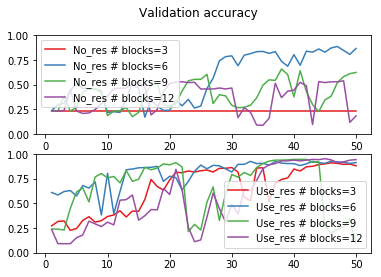

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.cm import get_cmap

# データ読み込み
no_res, use_res = [], []
for i in range(4):
    with open(f"history/no_res_{i*3+3:02d}.dat", "rb") as fp:
        no_res.append(pickle.load(fp))
    with open(f"history/use_res_{i*3+3:02d}.dat", "rb") as fp:
        use_res.append(pickle.load(fp))

xlabels = np.arange(50) + 1
cmap = get_cmap("Set1")


plt.subplot(2, 1, 1)
for i in range(len(no_res)):
    plt.plot(xlabels, no_res[i]["val_acc"], color=cmap(i), label="No_res # blocks="+str(i*3+3))
plt.legend()
plt.ylim((0, 1.0))

plt.subplot(2, 1, 2)
for i in range(len(no_res)):
    plt.plot(xlabels, use_res[i]["val_acc"],  color=cmap(i), label="Use_res # blocks="+str(i*3+3))
plt.legend()
plt.ylim((0, 1.0))

plt.suptitle("Validation accuracy")
plt.show()

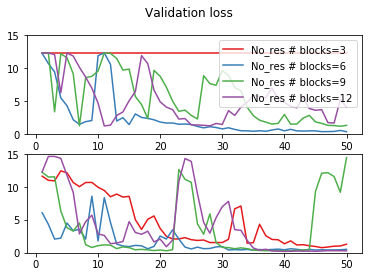

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.cm import get_cmap

# データ読み込み
no_res, use_res = [], []
for i in range(4):
    with open(f"history/no_res_{i*3+3:02d}.dat", "rb") as fp:
        no_res.append(pickle.load(fp))
    with open(f"history/use_res_{i*3+3:02d}.dat", "rb") as fp:
        use_res.append(pickle.load(fp))

xlabels = np.arange(50) + 1
cmap = get_cmap("Set1")


plt.subplot(2, 1, 1)
for i in range(len(no_res)):
    plt.plot(xlabels, no_res[i]["val_loss"], color=cmap(i), label="No_res # blocks="+str(i*3+3))
plt.legend()
plt.ylim((0, 15.0))

plt.subplot(2, 1, 2)
for i in range(len(no_res)):
    plt.plot(xlabels, use_res[i]["val_loss"],  color=cmap(i), label="Use_res # blocks="+str(i*3+3))
# plt.legend()
plt.ylim((0, 15.0))



plt.suptitle("Validation loss")
plt.show()

In [11]:
from keras.models import load_model
model = load_model('use_res_12.h5')
trafficLight_labels = np.array([
    'green',
    'red',
    'car',
    'others'
])

plt.figure(figsize=(32,32))
index = 100
right = 0
mistake = 0

In [ ]:
for i in range(index):
    image = x_test[i]
#   data = convertSize(image)
    data = image.reshape((1, 32, 32, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=1)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2,3]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    print(bestclass)
    
    if y_test[i] == bestclass:
        plt.title(trafficLight_labels[bestclass])
        right += 1
    else:
        plt.title(trafficLight_labels[bestclass] + '≠' + trafficLight_labels[int(y_test[i])], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [2]:
NB_CLASSES = 4
NB_EPOCH = 50
BATCH_SIZE = 256
VERBOSE = 1
SEPARATOR="-------------------------------------------"

np.random.seed(None)

In [11]:
class ResNettrafficLight:
    def __init__(self):
        self.trafficLight_inputShape=(32, 32, 3)
        self.momentum = SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
        self.label = ['red', 'green', 'car', 'others']
        self.ResNetModel = ResnetBuilder.build_resnet_34(self.trafficLight_inputShape, NB_CLASSES)
        plot_model(self.ResNetModel, to_file='ResNetModel.png', show_shapes=True, show_layer_names=True)
        self.ResNetModel.compile(optimizer=self.momentum, loss=losses.categorical_crossentropy, metrics=['acc'])
    
    def train_trafficLight(self, output_graph=True, save_weight=True):        
        trainDataAccuracy_array = []
        testDataAccuracy_array = []
        epoch_array = range(1, NB_EPOCH + 1)

        start_time = time.time()
        for epoch in range(NB_EPOCH):
            perm = np.random.permutation(x_train.shape[0])

            for i in range(0, x_train.shape[0], BATCH_SIZE):
                x_batch = x_train[perm[i : i + BATCH_SIZE]]
                y_batch = y_train[perm[i : i + BATCH_SIZE]]

                self.ResNetModel.train_on_batch(x_batch, y_batch)
            
            train_score = self.ResNetModel.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=VERBOSE)
            test_score = self.ResNetModel.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
            trainDataAccuracy_array.append(train_score[1])
            testDataAccuracy_array.append(test_score[1])
            interval = int(time.time() - start_time)
            print('epoch = {0:d} / {1:d} --- 実行時間 = {2:d}[sec] --- 1epochに掛かる平均時間 = {3:.2f}[sec]'.format(epoch + 1, NB_EPOCH, interval, interval / (epoch + 1)))
            print("Test score : {0:f} --- Test accuracy : {1:f}".format(test_score[0], test_score[1]))
        end_time = int(time.time() - start_time)

        if output_graph:
            plt.plot(epoch_array, trainDataAccuracy_array, label="train")
            plt.plot(epoch_array, testDataAccuracy_array, linestyle="--",label="test")
            plt.xlabel("epoch")
            plt.ylabel("accuracy")
            plt.title("ResNet with trafficLight ({0:d}[sec])".format(end_time))
            plt.legend()
            plt.show()
        
        if save_weight:
            self.ResNetModel.save_weights('ResNetModel_trafficLight_weights.h5')
    
    def Load_weight(self, weight_path):
        self.ResNetModel.load_weights(weight_path)
    
    def ResNet_predict_from_oneFile(self, filePath, file_name, debug=True):
        img = Image.open(filePath)
        img_resize = img.resize((self.trafficLight_inputShape[0], self.trafficLight_inputShape[1]), Image.LANCZOS)
        img2np = np.asarray(img_resize)
        img2np.flags.writeable = True
        img2np.astype('float32')
        img2np_norm = np.true_divide(img2np, 255)[np.newaxis, :, :, :]

        print(SEPARATOR)
        if debug:
            print(img_resize.size)
            print(img2np.shape)
            print(img2np_norm.shape)
            img_resize.show()
        
        result = self.ResNetModel.predict(img2np_norm, batch_size=1)

        if debug:
            print(result)

        print(file_name + 'は' + self.label[np.argmax(result)] + 'です')
        print(SEPARATOR)

In [12]:
def predict(weight_path=None):
    net = ResNettrafficLight()

    if weight_path is None:
        net.train_trafficLight(output_graph=True, save_weight=True)
    else:
        net.Load_weight(weight_path)
    
    for img_path in utility.find_all_files('./trafficLight_predict_my_img'):
        if (img_path[-4:] == '.jpg') or (img_path[-4:] == '.png'):
            net.ResNet_predict_from_oneFile(img_path, utility.filePath2fileName(img_path, include_extended=True))


def main():
    weight = None

    if os.path.exists('ResNetModel_trafficLight_weights.h5'):
        weight = 'ResNetModel_trafficLight_weights.h5'
    
    predict(weight)

In [17]:
if __name__ == "__main__":
    main()

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.